# Regularization Technique for Deep Neural Networks: Dropout and L2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots width(7.0) ,height(4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Loading And Plotting Dataset

In [6]:
def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0,:], s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

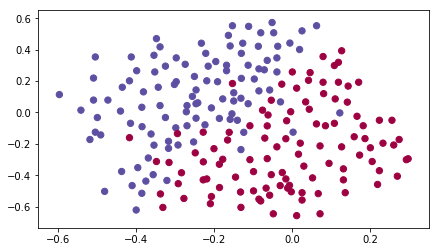

In [7]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [9]:
print(train_X.shape) # Examples are in column form i.e. each column represents each example. Each example has 2 features i.e. co-ordinates in cartesian plane.
print(train_Y.shape) # Blue dots are positive(1) and red dots are negative(0).

(2, 211)
(1, 211)


# Three Layer Neural Network

Now we will train a 3 layered Neural Network in which the 2 hidden layers use Relu activation and the output layer uses Sigmoid Activation. 
The function parameter keep_prob will decide whether we want forward propagation with dropouts or Not. Before writing the model function, we will write the helper functions which will be used in the model function.  

# Helper Functions 


In [24]:
# Xavier Initialization to initialize parameters.

def initialize_parameters_xavier(layers_dims):
    
    """Parameter: layers_dims is same as in the function initialize_parameters_zeros"""
    parameters={}
    L=len(layers_dims)
        
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1)) 
            
        
    return parameters

In [25]:
def relu(x):
    """This function computes relu of x. Again x can be a scalar or a numpy array."""
    r=np.maximum(0,x)
    
    return r

In [26]:
def sigmoid(x):
    """This function computers sigmoid of x which can be scalar or numpy array of any size.
         If x is array of any size, the function computes element wise sigmoid. """
    s=1/(1+np.exp(-x))
    
    return s

# Simple Forward Propagation

In [27]:
def forward_propagation(X , parameters):
    
    # retriving parameters from the python dictionary.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Computing First layer which is a Relu activated layer.
    z1 = np.dot(W1,X) + b1  # X is matrix where each column represents an example. So, after this computation, z1 is also a matrix, where first column represents first layer(linear) of first training example.
    # Second column represents first layer(linear part ) of second example and so on.
    a1 = relu(z1) # a1 has same dimensions as z1. Now, each column of a1 represents first activated layer of each example.
    
    # Computing Second hidden layer.
    z2 = np.dot(W2,a1) + b2
    a2 = relu(z2)
    
    # Computing Output layer:
    z3 = np.dot(W3,a2) + b3
    a3 = sigmoid(z3)  # a3 has 1 row and m( number of examples) columns where each column represent y_hat
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) # Storing all activation layers in cache tuple which will be used in backpropagation.
    
    return a3, cache

# Simple Back Propagation: Without Regularization


In [28]:
def backward_propagation(X, Y, cache):
    """
    This function implements back propagation to calculate gradients dW's and db's. 
    
    """
    m = X.shape[1]  # Number of training examples.
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache # Retrieving activations and parameters from cache.
    
    dz3 = 1./m * (a3 - Y) # dz3 is derivative of Loss wrt z3. It can be calculated directly subtracting y_hat and y for all examples.
    dW3 = np.dot(dz3, a2.T) # dW3 is derivative of Loss wrt W3.
    db3 = np.sum(dz3, axis=1, keepdims = True) # db3 is derivative wrt 
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

# Forward Propagation with Dropout

In [187]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    
    np.random.seed(1)
    # retrieving parameters from the dictionary
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Computing First layer which is a Relu activated layer.
    z1 = np.dot(W1 , X) + b1 # X is matrix where each column represents an example. So, after this computation, z1 is also a matrix, where first column represents first layer(linear) of first training example.
    # Second column represents first layer(linear part ) of second example and so on.
    a1 = relu(z1)
    
    # Below is the code to shutoff (making 0) some neurons of a1.
    # Notice that different neurons of layer 1 shutsoff for different examples.
    d1 = np.random.rand(a1.shape[0] , a1.shape[1])  # initialize a matrix d1 with shape same as a1. All values are between 0 and 1 
    d1 = (d1 < keep_prob)  # Converting d1 into matrix of 0 and 1
    a1 = a1 * d1  # Element wise multiplication. This will make some neurons 0 because some entries are 0 in d1.
    a1 = a1 / keep_prob # To scale up value of neurons that are still on.
    
    # Second Layer
    
    z2 = np.dot(W2 , a1 ) + b2
    a2 = relu(z2)
    
    d2 = np.random.rand(a2.shape[0] , a2.shape[1])
    d2 = (d2 < keep_prob)
    a2 = a2 * d2
    a2 = a2 / keep_prob
    
    z3 = np.dot(W3 , a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, d1, a1, W1, b1, z2, d2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache
    
    

# Backward Propagation with Dropouts:

Backward propagation with dropout is same as simple backward propagation. Now, we have to do the same thing with da2, da1 which we did with a2 and a1 i.e. apply same mask 'd' to shutoff. This 'd' is available in the cache which we returned while forward_propagation_with_dropout.

In [191]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob): 
    
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA2 = dA2 * D2              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1 = dA1 * D1              # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    ### END CODE HERE ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

# Backward Propagation with L2 Regularization:

Back propagation with L2 is same as in simple case. We just add derivative of 1 more term which we added in the compute_cost_with_regularization function below.

In [31]:
def backward_propagation_with_regularization(X , Y, cache , lambd ):
    
    m = X.shape[1]  # Number of training examples.
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y) # dz3 is derivative of Loss wrt z3. It can be calculated directly subtracting y_hat and y for all examples.
    dW3 = np.dot(dz3, a2.T) + lambd * W3 / m # dW3 is derivative of Loss wrt W3.
    db3 = np.sum(dz3, axis=1, keepdims = True) # db3 is derivative wrt
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0)) 
    dW2 = np.dot(dz2, a1.T) + lambd * W2 / m
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T) + lambd * W1 / m
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    
    return gradients
    
    

In [79]:
print(train_Y.shape[1])

211


# Cost Function.

In [126]:
def compute_cost(a3,Y):
   
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

# Cost Function with Regularization

The cost function with regularization is same as cross-entropy loss + lambd * [sum of squares of all W] / (2 * m)

In [33]:
# Cost function with regularization.

def compute_cost_with_regularization(a3, Y, parameters, lambd):
    
    m = Y.shape[1]
    # Retrieving parameters from dictionary.
    W1 = parameters["W1"] 
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(a3 , Y)
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost
    

# Update Parameters Using Gradient Descent


In [34]:
def update_parameters(parameters, grads, learning_rate):
    """
   This function updates parameters using gradient descent algorithm.

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters


# Predict Function

The function below predicts the value of y for an example(or test data) using forward propagation.

In [35]:
def predict(X,y,parameters):
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int) # Initializing predicted value vector y_hat corresponding to X
    
    # Forward Propagation
    a3,cache = forward_propagation(X , parameters)
    
    # Converting probabilties to 0/1 using 0.5 as threshold.
    for i in range(0,a3.shape[1]):
        if ( a3[0,i] > 0.5):
            p[0,i] = 1
        else:
            p[0,i] = 0
            
     
    # Printing the accuracy
    print("Accuracy of the model is : " + str(np.mean((p[0,:]==y[0,:]))))
    
    return p
             

# Plotting Decision Boundary

In [39]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1  # Calculating the minimum and maximum value of  x co-ordinate of  cartesian plane and giving a padding of 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1  # Similarly for y co-ordinate of cartesain plane.
    
    h = 0.01
    
    # Generate a grid of points with distance h between them
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Returns co-ordinate matrices from co-ordinate vectors.
    
    # Predict the function value for every x1,y1 pair on the grid
    
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour(shaded region based on Z i.e. predicted value) and training examples.
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0,:], cmap=plt.cm.Spectral)
    plt.show()

In [40]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

# Model Function

In [141]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters_xavier(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

# Training Model Without Regularization


Cost after iteration 0: 0.6887183079655288
Cost after iteration 10000: 0.18713405483435244
Cost after iteration 20000: 0.1651707006732556


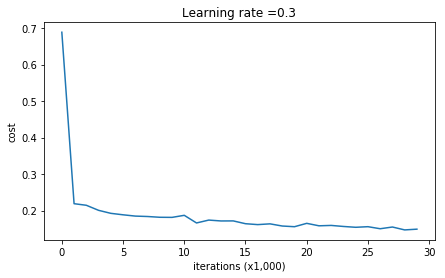

On the training set:
Accuracy of the model is : 0.9336492891
On the test set:
Accuracy of the model is : 0.925


In [133]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

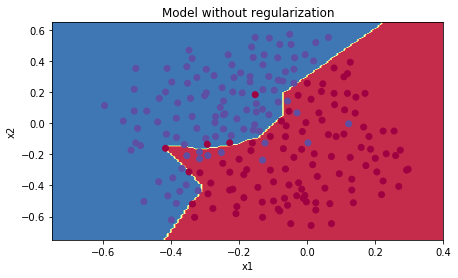

In [134]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# Training Model With L2 Regularization.


Cost after iteration 0: 0.7194381341758391
Cost after iteration 10000: 0.26764948438612396
Cost after iteration 20000: 0.26530209053920384


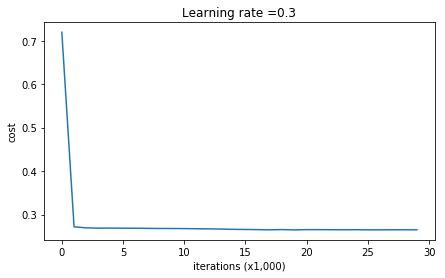

On the train set:
Accuracy of the model is : 0.928909952607
On the test set:
Accuracy of the model is : 0.93


In [135]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

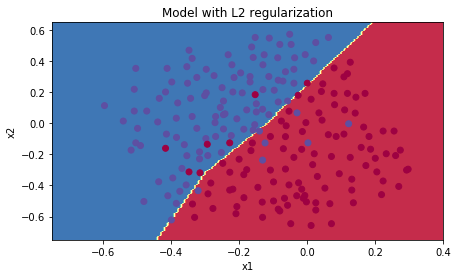

In [136]:
plt.title("Model with L2 regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# Training Model With Dropout

Cost after iteration 0: 0.6910175809916411


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 10000: 0.036388980540333564
Cost after iteration 20000: 0.03206638745070821


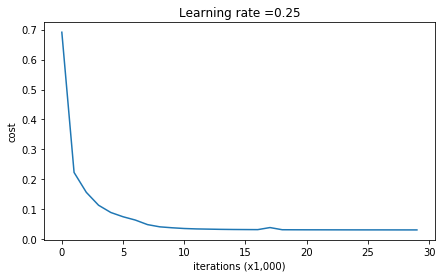

On the train set:
Accuracy of the model is : 0.928909952607
On the test set:
Accuracy of the model is : 0.92


In [199]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.25)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

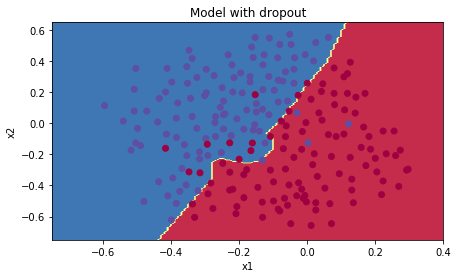

In [200]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)